In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import digamma
%matplotlib inline
from ct_charachterization.utility.utils import central_gamma_pdf
from glob import glob
import pydicom as dicom
import dicom_numpy
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.stats import mode
import matplotlib.patches as patches
from ct_charachterization import run_third_algorithm_works, run_third_algorithm_tries
from ct_charachterization.utility.utils import expand, contract

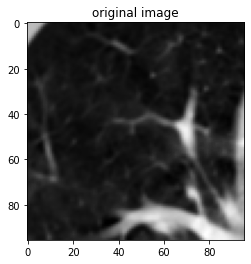

/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:10: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


iteration: 1, error: 0.1222940508373219
iteration: 2, error: 0.0


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  theta_before_expansion = np.array([initial_pi, initial_alpha, initial_beta])


iteration: 1, error: 0.26056151999985916
iteration: 2, error: 0.004762949050374908
first False
second False
var False
zero var False


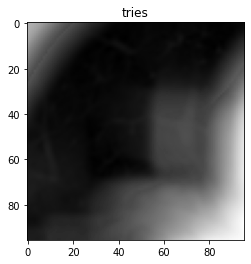

In [2]:
img = np.load(f'../resources/2d_img.npy')[90:410, 90:410]
luna = np.load(f'../resources/luna_cropped.npy')
mu_9 = np.array([-987, -810, -540, -370, -160, 0, 100, 240, 340])
mu_5 = np.array([-1000, -700, -84, 40, 200])


y = luna[:128,:128]
plt.imshow(y[16:112,16:112], cmap='gray')
plt.title("original image")
plt.show()

# big_y = expand(small_img=y, neighborhood_size=32)
# big_y = big_y[16 * 32:(128-16) * 32, 16 * 32:(128-16) * 32]
# plt.imshow(big_y, cmap='gray')
# plt.title("expanded image")
# plt.show()


# big_y_stab_works = run_third_algorithm_works(big_y, mu_9, non_central=True, constant_c=10, neighborhood_size=32, max_iter=5)
# y_stab_works = contract(big_img=big_y_stab_works, neighborhood_size=32)
# plt.imshow(y_stab_works, cmap='gray')
# plt.title("works")
# plt.show()


y_stab_tries = run_third_algorithm_tries(y, mu_9, non_central=True, constant_c=10, neighborhood_size=32, max_iter=5)
plt.imshow(y_stab_tries, cmap='gray')
plt.title("tries")
plt.show()

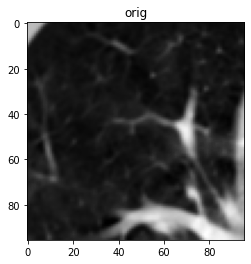

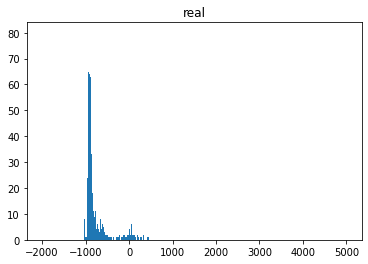

min: -1024, mean: -772.1635199652778, max: 448


In [6]:
plt.imshow(y[16:112,16:112], cmap='gray')
plt.title("orig")
plt.show()

flat = y[16:112,16:112].flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-2000, 5000, 1)))
plt.title("real")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')

In [3]:
print(np.min(y_stab_tries), np.max(y_stab_tries))

-1949.8374541149335 4406.891533045023


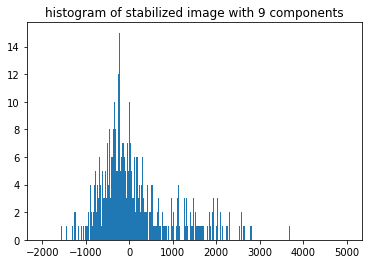

min: -1949.8374541149335, mean: 151.65413481431594, max: 4406.891533045023


In [4]:
flat = y_stab_tries.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-2000, 5000, 1)))
plt.title("histogram of stabilized image with 9 components")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')

In [11]:
from copy import deepcopy
from ct_charachterization import run_second_algorithm
from ct_charachterization.utility.utils import expand, contract, broadcast_tile, block_matrix, sum_over_each_neighborhood_on_blocked_matrix

mu= deepcopy(mu_9) / 100
delta = -1030 / 100
y = deepcopy(luna[:128,:128]) / 100
neighborhood_size=32
max_iter=5
tol=0.01
constant_c=2
non_central=True
first_shape = y.shape[0]
second_shape = y.shape[1]
big_y = expand(small_img=y, neighborhood_size=neighborhood_size)
half_neigh = int(neighborhood_size / 2)
big_y = big_y[half_neigh * neighborhood_size:(first_shape - half_neigh) * neighborhood_size,
        half_neigh * neighborhood_size:(second_shape - half_neigh) * neighborhood_size]
big_jay = len(mu)
if non_central:
    mu = mu - delta
    big_y = big_y - delta
theta, gamma = run_second_algorithm(big_y, mu=mu, neighborhood_size=neighborhood_size, delta=delta,
                                    max_iter=max_iter,
                                    tol=tol)
pi = theta[0, ...]
shape_of_each_neighborhood = tuple([neighborhood_size for _ in big_y.shape])
blocked_y = block_matrix(mat=big_y, neighborhood_shape=shape_of_each_neighborhood)
blocked_radical_y = block_matrix(mat=np.sqrt(big_y), neighborhood_shape=shape_of_each_neighborhood)
moments_size = tuple([big_jay] + [int(i / neighborhood_size) for i in big_y.shape])
first_local_sample_conditioned_moment = np.empty(moments_size, dtype=float)
second_local_sample_conditioned_moment = np.empty(moments_size, dtype=float)
for j in range(big_jay):
    blocked_gamma_j = block_matrix(mat=gamma[..., j], neighborhood_shape=shape_of_each_neighborhood)
    first_numerator_summation = np.nan_to_num(
        sum_over_each_neighborhood_on_blocked_matrix(blocked_gamma_j * blocked_radical_y))
    second_numerator_summation = np.nan_to_num(
        sum_over_each_neighborhood_on_blocked_matrix(blocked_gamma_j * blocked_y))
    denominator_summation = sum_over_each_neighborhood_on_blocked_matrix(blocked_gamma_j)
    first_local_sample_conditioned_moment[j, ...] = first_numerator_summation / denominator_summation
    second_local_sample_conditioned_moment[j, ...] = second_numerator_summation / denominator_summation
first_local_sample_conditioned_moment = np.sum(first_local_sample_conditioned_moment * pi, axis=0)
print('first', np.isnan(first_local_sample_conditioned_moment).any())
second_local_sample_conditioned_moment = np.sum(second_local_sample_conditioned_moment * pi, axis=0)
print('second', np.isnan(second_local_sample_conditioned_moment).any())
local_sample_variance = second_local_sample_conditioned_moment - np.power(first_local_sample_conditioned_moment, 2)
print('var', np.isnan(local_sample_variance).any())
print('zero var', (local_sample_variance == 0).any())
y_stab = (constant_c * (np.sqrt(y[half_neigh:first_shape - half_neigh,
                                half_neigh: second_shape - half_neigh]) - first_local_sample_conditioned_moment) / np.sqrt(
    local_sample_variance)) + second_local_sample_conditioned_moment

iteration: 1, error: 0.17585538819316116
iteration: 2, error: 1.5003974074827292e-17
iteration: 1, error: 0.28727806740174144
iteration: 2, error: 0.004368633093398699
first False
second False
var False
zero var False


<ipython-input-11-2219e9040402>:49: RuntimeWarning: invalid value encountered in sqrt
  y_stab = (constant_c * (np.sqrt(y[half_neigh:first_shape - half_neigh,


SyntaxError: 'return' outside function (<ipython-input-11-2219e9040402>, line 52)

In [18]:
y

array([[ -7.28,  -7.9 ,  -8.97, ...,  -9.39,  -9.18,  -8.93],
       [ -8.38,  -9.01,  -9.63, ...,  -9.3 ,  -9.28,  -8.93],
       [ -9.47,  -9.87, -10.06, ...,  -9.13,  -9.19,  -8.68],
       ...,
       [ -8.77,  -8.83,  -8.93, ...,   2.68,   2.76,   2.81],
       [ -8.8 ,  -8.84,  -8.9 , ...,   2.52,   2.64,   2.55],
       [ -8.9 ,  -8.86,  -8.8 , ...,   2.68,   2.74,   2.45]])

In [16]:
np.nonzero(local_sample_variance <= 0)

(array([], dtype=int64), array([], dtype=int64))

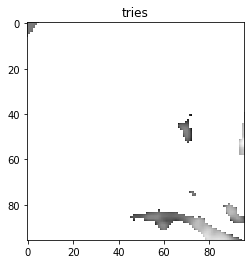

In [12]:
plt.imshow(y_stab, cmap='gray')
plt.title("tries")
plt.show()

Results above have a lot in common with the right image below which is the stabilized image from the paper (Fig. 12):

![fig12](../resources/figs/fig12.png)

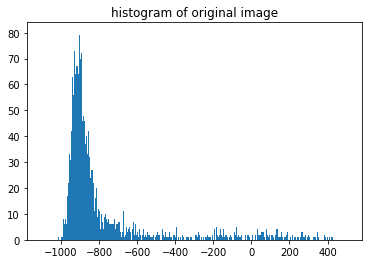

min: -1024, mean: -772.1635199652778, max: 448


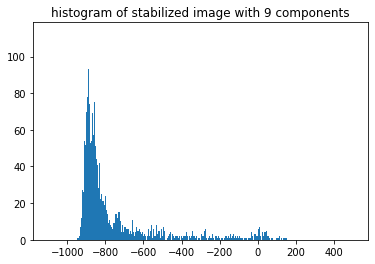

min: -948.8146033676445, mean: -753.4699516250093, max: 190.5448205490743


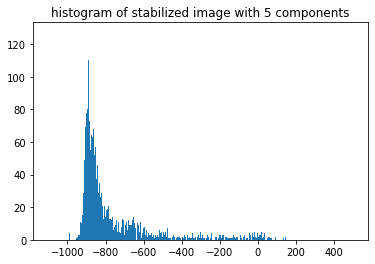

min: -989.4099569228121, mean: -752.7355853409485, max: 175.37364829650323


In [12]:
flat = y[16:112,16:112].flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram of original image")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')


flat = y_stab_9.flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram of stabilized image with 9 components")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')



flat = y_stab_5.flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram of stabilized image with 5 components")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')

# Using 9 components for the whole image

(320, 320)


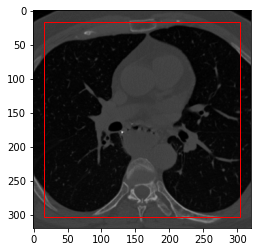

In [2]:
print(img.shape)
fig1, ax1 = plt.subplots(1)
ax1.imshow(img, cmap='gray')
rect = patches.Rectangle((16, 16),288,288,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.show()
mu = np.array([-987, -810, -540, -370, -160, 0, 100, 240, 340])

In [3]:
def get_block_stabilized_img(y, mu):
    neigh = 32
    block = 96
    w = y.shape[0]
    h = y.shape[1]
    y_stab = np.empty((w-neigh, h-neigh))
    for i in range(int((w-neigh)/block)):
        for j in range(int((h-neigh)/block)):
            print(i,j)
            big_y = expand(small_img=y[i*block:(i+1)*block + neigh, j*block:(j+1)*block+neigh], neighborhood_size=neigh)
            big_y = big_y[int(neigh/2) * neigh:(block+int(neigh/2)) * neigh, int(neigh/2) * neigh:(block+int(neigh/2)) * neigh]
            big_y_stab = run_third_algorithm(big_y, mu, non_central=True, constant_c=10, neighborhood_size=neigh, max_iter=4, tol=0.01)
            ys = contract(big_img=big_y_stab, neighborhood_size=neigh)
            y_stab[i*block:(i+1)*block, j*block:(j+1)*block] = ys
    return y_stab

In [4]:
y = img
y_stab = get_block_stabilized_img(y, mu_9)

0 0
iteration: 1, error: 0.4719516125565326
iteration: 2, error: 4.237232868399964e-16


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  theta_before_expansion = np.array([initial_pi, initial_alpha, initial_beta])
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:10: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


iteration: 1, error: 0.48409983486041946


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/utility/utils.py:72: RuntimeWarning: overflow encountered in power
  form = np.nan_to_num(np.power(y, (alpha - 1)) * np.exp(-y / beta))
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/utility/utils.py:73: RuntimeWarning: overflow encountered in multiply
  denominator = np.nan_to_num(np.power(beta, alpha) * gamma(alpha))


iteration: 2, error: 0.003839963087686636


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:36: RuntimeWarning: invalid value encountered in sqrt
  y_stab = (constant_c * (np.sqrt(y) - first_local_sample_conditioned_moment) / np.sqrt(
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:36: RuntimeWarning: invalid value encountered in true_divide
  y_stab = (constant_c * (np.sqrt(y) - first_local_sample_conditioned_moment) / np.sqrt(


0 1
iteration: 1, error: 0.5245445296708208
iteration: 2, error: 2.0838305656979472e-14
iteration: 1, error: 0.6182570258836361
iteration: 2, error: 7.558938481662933e-14
0 2
iteration: 1, error: 0.41655617242453163
iteration: 2, error: 1.2741136751705083e-14
iteration: 1, error: 0.4588860075953997
iteration: 2, error: 0.005151556833511197
1 0
iteration: 1, error: 0.14435458985550806
iteration: 2, error: 9.005134813627573e-15
iteration: 1, error: 0.24176430412758307
iteration: 2, error: 8.654858958345668e-15
1 1
iteration: 1, error: 0.7642054942980052
iteration: 2, error: 1.1884153966471587e-14
iteration: 1, error: 0.6025885139801163


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/utility/utils.py:72: RuntimeWarning: invalid value encountered in multiply
  form = np.nan_to_num(np.power(y, (alpha - 1)) * np.exp(-y / beta))


iteration: 2, error: 0.0025061814422934307


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:30: RuntimeWarning: invalid value encountered in true_divide
  first_local_sample_conditioned_moment[..., j] = np.nan_to_num(first_numerator_summation / denominator_summation)
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:32: RuntimeWarning: invalid value encountered in true_divide
  second_numerator_summation / denominator_summation)


1 2
iteration: 1, error: 0.7631948492379708
iteration: 2, error: 6.046559905074262e-16
iteration: 1, error: 0.464563241220584
iteration: 2, error: 0.005443582427604519
2 0
iteration: 1, error: 0.3577941212895907
iteration: 2, error: 1.1073585719865629e-14
iteration: 1, error: 0.34914909380156023
iteration: 2, error: 1.2424133684235985e-14
2 1
iteration: 1, error: 0.5470701158690852
iteration: 2, error: 2.5441938230033912e-15
iteration: 1, error: 0.5114284330791553
iteration: 2, error: 1.568768206110781e-14
2 2
iteration: 1, error: 0.35933817290351694
iteration: 2, error: 1.9923862901101145e-16
iteration: 1, error: 0.31720999333480804
iteration: 2, error: 1.2075026050314681e-14


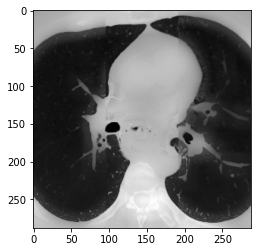

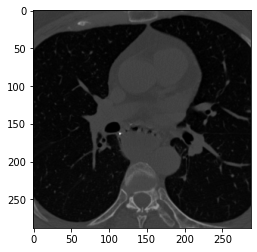

In [5]:
plt.imshow(y_stab, cmap='gray')
plt.show()
plt.imshow(y[16:304,16:304], cmap='gray')
plt.show()

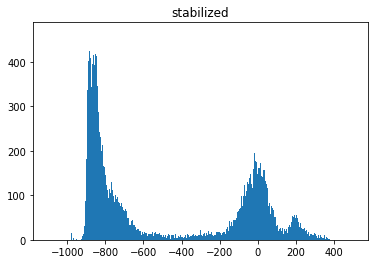

min: -982.1206470432381, mean: -473.7239634866142, max: 383.5093826449149


In [8]:
flat = y_stab.flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("stabilized")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')

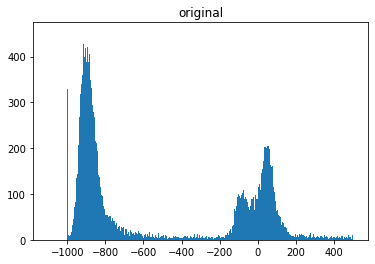

min: -1000, mean: -481.90190972222223, max: 3000


In [9]:
flat = y[16:304,16:304].flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("original")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')